# Aufgabe-F-FilmDialoge

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/F_dialoge herunter
    * Die Daten sind geschützt. 
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen "ml_LaB_4$" anmelden. 
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei. 
    * Finden Sie keine solche Datei sind die Daten selbst erklärend. 
    
    



## Aufgabe

Die Daten-Sammlung 
* besteht aus Dialogen aus verschiedensten Filmen
* ist in der Readme Datei beschrieben

Erstellen Sie aus den einen Chatbot, der auf eine Frage mit einer Antwort im "Filmjargon" antwortet! 
* Verwenden Sie tiefe Neuronale Netze zu Erstellen des Chatbots! 
* Passen Sie den Chatbot so an, dass er für unterschiedliche Film-Genres unterschiedlich antwortet! 


# Lösung

Die Lösung der Aufgabe besteht aus mehreren Teilschritten, welche im Folgenden kurz genannt werden:

* Daten einlesen
* Daten vorverarbeiten
* Model erstellen
* Model trainieren
* Model abspeichern
* Model ausführen


# Abhängigkeiten des Projekts

* Tensorflow 2.8.2

In [1]:
import tensorflow as tf
import random
import re
import numpy


# Eigene Abhängigkeiten des Projekts

* 

In [2]:
import sys
import importlib
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

import data_helper as dh

importlib.reload(dh)

<module 'data_helper' from 'g:\\My Drive\\Dokumente\\Studium\\Theorie\\Vorlesungen\\Semester 5\\Machine Learning\\Projekt\\src\\data_helper.py'>

# Daten einlesen

Hier werden zuerst die rohen Daten eingelesen und innerhalb der Hilfsfunktion "readDataToLines" mit des "newline" Zeichen getrennt. Die Daten werden zwei Listen gespeichert, welche dann zurückgegeben werden.
Verwendet wurden folgende Funktionen:

* "open" um die Datei zu öffnen
* "read" um die Datei zu lesen
* "split" um die Daten anhand des "newline" Zeichen zu trennen und in einer Liste zu speichern

In [3]:
# read the data from the files
movie_lines, movie_conversations = dh.readDataToLines("data/unzipped/movie_lines.txt", "data/unzipped/movie_conversations.txt")

# Daten vorverarbeiten

In [4]:
# convert the data into a list of conversations
from matplotlib import pyplot as plt


conversations_list = dh.readConversationsToList(movie_conversations)

# create a dictionary that maps each line id to the corresponding line
id2line = dh.readLinesToDict(movie_lines)

# remove all unnecessary characters from the lines and replace short forms with the full words
id2line = dh.cleanLines(id2line)

# split the conversations into requests and responses, each answer is used as a request for the next answer
request, response = dh.splitConversationsToRequestAndResponse(conversations_list, id2line)

# delete temporary variables
del(movie_lines, movie_conversations, conversations_list, id2line)

# optional: limit the size of the dataset
request = request[0:len(request)]
response = response[0:len(response)]

# optional: limit the size of the answers by word count
max_wordcount = 100
for i in range(len(response)):
    # split the response into words
    temp = response[i].split()

    # limit the size of the list containing one word per entry to the maximum word count
    temp = temp[0:max_wordcount]

    # convert the list back to a string, whose word count is limited by the maximum word count
    response[i] = " ".join(temp)

# optional: limit the size of the requests by word count
max_wordcount = 100
for i in range(len(request)):
    # split the request into words
    temp = request[i].split()

    # limit the size of the list containing one word per entry to the maximum word count
    temp = temp[0:max_wordcount]

    # convert the list back to a string, whose word count is limited by the maximum word count
    request[i] = " ".join(temp)

del max_wordcount

# get a dictionary of all unique words with their frequency
word2count = dh.getWord2Count(request, response)

# filter out words with a frequency of 5 or less
min_wordFrequency = 5
word2count = {k:v for k,v in word2count.items() if v > min_wordFrequency}

del(min_wordFrequency)

# create a dictionary that maps each word to a unique integer, used in the encoder
# tokens: <S> (Start), <E> (End), <N> (Null), <F> (Filler)
# add the tokens to the front of the dictionary to optimize searching while shifting the indices of the other words by 4
word2index = {}
word2index["<F>"] = 0
word2index["<S>"] = 1
word2index["<E>"] = 2
word2index["<N>"] = 3
word2index |= {k:v+4 for v,k in enumerate(word2count.keys())} #merge dictionaries
# this line of code creates a dictionary word2index by using a dictionary comprehension
# the comprehension iterates over the keys of the dictionary word2count and assigns each key a value that is the index of the key plus 4 (the first 4 indices are reserved for the tokens)
# v takes the values 0, 1, 2, ... and k takes the values of the keys of the word2count dictionary
# the enumerate function generates a sequence of index, value pairs from the keys of the word2count dictionary
# the dictionary comprehension creates a new dictionary with the keys from word2count as the keys of word2index and the values of word2index being the index of the keys in word2count plus 4.

# invert the dictionary word2index to create a dictionary that maps each integer to a unique word, used in the decoder
index2word = {k:v for v,k in word2index.items()}

# save the dictionaries to the disk to use them later
dh.saveDictionary(word2index, "data/word2index.dict")
dh.saveDictionary(index2word, "data/index2word.dict")

# encapsule the requests and responses with the tokens <S> (Start) and <E> (End)
request, response = dh.encapsuleWithTokens(request, response, "<S>", "<E>")

del(word2count)

inputEncoder = dh.translateToNumeric(request, word2index, "<N>")
inputDecoder = dh.translateToNumeric(response, word2index, "<N>") # what the model should predict = training data, skips the decoding step while training the model

del(request, response)









Durch die teils große Anzahl an Wörtern innerhalb einer Sequenz, wird für die OneHot Encoding sehr viel Speicherplatz benötigt. (ca. 1,6 TB)
Um dieses Problem zu lösen, wurden die Sequenzen auf ihre Länge untersucht und die Häufigkeit der verschiedenen Längen in einem Diagramm dargestellt. 
In diesem lässt sich erkennen, dass Sequenzen mit einer Sequenzlänge von 15 Wörtern und mehr nur sehr selten auftreten. Um die Sequenzen zu kürzen, wurden alle Sequenzen mit einer Länge von 15 Wörtern und mehr auf eine Länge von 15 Wörtern gekürzt. Zusätzlich musste die Menge der Sequenzen auf 30.000 begrenzt werden, da Tensorflow für das OneHot Encoding sonst zu viel Speicher benötigt.

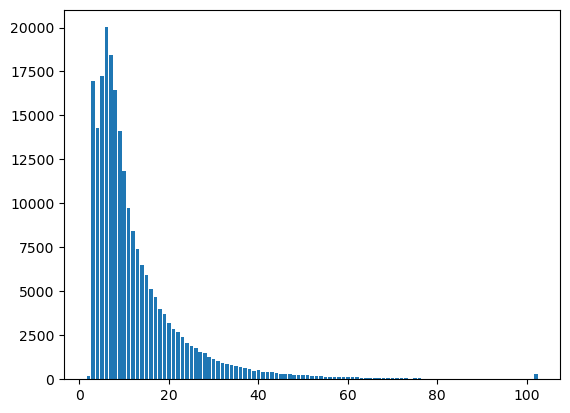

In [5]:
# get the length of each line of the requests and save the occurrences in a dictionary
lengths = {}
for sentence in inputEncoder:
    length = len(sentence)
    if length in lengths:
        lengths[length] += 1
    else:
        lengths[length] = 1

# plot the occurrences of the lengths of the requests
plt.bar(lengths.keys(), lengths.values())
plt.show()

# remove every request and its corresponding response if one of them has more words than 15 
inputEncoder, inputDecoder = dh.removeLongSequences(inputEncoder, inputDecoder, 15)

# get the maximum length of the requests
max_length_request = max([len(x) for x in inputEncoder])
# get the maximum length of the responses
max_length_response = max([len(x) for x in inputDecoder])
# get the maximum length of the requests and responses
max_length = max(max_length_request, max_length_response) # (+2 for the tokens <S> and <E>)

In [6]:
# use the keras function pad_sequences to pad the requests and responses with zeros (which represent a filling token) to the maximum length
inputEncoder = tf.keras.preprocessing.sequence.pad_sequences(inputEncoder, maxlen=max_length, padding="post", truncating="post")
inputDecoder = tf.keras.preprocessing.sequence.pad_sequences(inputDecoder, maxlen=max_length, padding="post", truncating="post")

# remove start token from decoder input so that the decoder doesn't learn to just copy the start token to each output, don't remove the end token because the decoder should learn when to stop with generating output
inputDecoder = inputDecoder[:, 1:]

# limit the size of the inputs to 30000
inputEncoder = inputEncoder[0:30000]
inputDecoder = inputDecoder[0:30000]


# convert the decoder input to a one-hot encoded vector which the model can use
inputDecoder = tf.keras.utils.to_categorical(inputDecoder, num_classes=len(word2index))

# Model erstellen

# Model trainieren

# Model abspeichern

# Model ausführen